# Compression examples
In this notebook we compare constraints on cosmological parameters obtained with different types of compressions (shapefit, direct).
Notebooks fs_shapefit_examples.ipynb & fs_direct_examples.ipnyb must be run first to produce the samples needed in this notebook.

## BAO compression
As a warm-up, what constraints on $\Omega_m$ do we obtain from an isotropic BAO fit?

In [1]:
from desilike.samples import Chain
from desilike import setup_logging

setup_logging()
chain = Chain.load('_tests/chain_bao_0.npy').remove_burnin(0.3)
z = 1.

[000000.02] [0/1] 01-30 09:35  Chain                     INFO     Loading _tests/chain_bao_0.npy.


In [2]:
import numpy as np

from desilike.theories.primordial_cosmology import Cosmoprimo
from desilike.observables.galaxy_clustering import BAOCompressionObservable
from desilike.likelihoods import ObservablesGaussianLikelihood

cosmo = Cosmoprimo(fiducial='DESI')
cosmo.params = {'Omega_m': {'prior': {'limits': [0.05, 0.9]},
                            'ref': {'limits': [0.30, 0.33]},
                            'latex': '\Omega_{m}'}}
quantities = ['qiso']
observable = BAOCompressionObservable(data=chain, covariance=chain, cosmo=cosmo, z=z, quantities=quantities)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

# Note that you can directly pass arrays as data and covariance, in addition to "quantities"
quantities = ['qiso']
data = chain.choice(params=quantities, return_type='nparray')
covariance = chain.cov(params=quantities, return_type='nparray')
observable = BAOCompressionObservable(data=data, covariance=covariance, quantities=quantities, z=z)
likelihood2 = ObservablesGaussianLikelihood(observables=[observable])
assert np.allclose(likelihood2(Omega_m=0.29), likelihood(Omega_m=0.29))

[000000.20] [0/1] 01-30 09:35  BAOCompressionObservable  INFO     Found BAO quantities ['qiso'].
[000000.34] [0/1] 01-30 09:35  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.34] [0/1] 01-30 09:35  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.34] [0/1] 01-30 09:35  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.35] [0/1] 01-30 09:35  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.35] [0/1] 01-30 09:35  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000000.58] [0/1] 01-30 09:35  BAOCompressionObservable  INFO     Found BAO quantit

In [3]:
# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=4))
emulator.set_samples(ref_scale=1.)
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000001.47] [0/1] 01-13 20:56  Emulator                  INFO     Varied parameters: ['Omega_m'].
[000001.47] [0/1] 01-13 20:56  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities'] outputs.
[000001.47] [0/1] 01-13 20:56  Differentiation           INFO     Varied parameters: ['Omega_m'].
[000001.77] [0/1] 01-13 20:56  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.


In [4]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000002.03] [0/1] 01-13 20:56  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000005.26] [0/1] 01-13 20:56  EmceeSampler              INFO     Diagnostics:
[000005.26] [0/1] 01-13 20:56  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0955; not < 0.04.
[000005.26] [0/1] 01-13 20:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0955.
[000005.27] [0/1] 01-13 20:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.285.
[000005.27] [0/1] 01-13 20:56  EmceeSampler              INFO     - max Geweke is 0.213.
[000005.27] [0/1] 01-13 20:56  EmceeSampler              INFO     - Geweke p-value is nan.
[000005.27] [0/1] 01-13 20:56  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 13.9.
[000008.14] [0/1] 01-13 20:56  EmceeSampler              INFO     Diagnostics:
[000008.14] [0/1] 01-13 20:56  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 

[000026.07] [0/1] 01-13 20:56  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


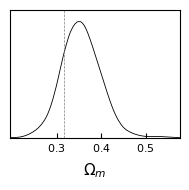

In [5]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.bao.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})

## ShapeFit compression
Now turn to shapefit compression.

In [6]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

chain = Chain.load('_tests/chain_fs_shapefit_0.npy').remove_burnin(0.3)

quantities = ['qpar', 'qper', 'f', 'dm']
observable = ShapeFitCompressionObservable(data=chain, covariance=chain, z=z, quantities=quantities)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples(ref_scale=1.)
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000026.42] [0/1] 01-13 20:56  Chain                     INFO     Loading _tests/chain_fs_shapefit_0.npy.
[000026.43] [0/1] 01-13 20:56  ShapeFitCompression       INFO     Found BAO quantities ['qpar', 'qper'].
[000026.43] [0/1] 01-13 20:56  ShapeFitCompression       INFO     Found FS quantities ['df', 'dm'].


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo-1.0.0-py3.9.egg/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000029.64] [0/1] 01-13 20:56  Emulator                  INFO     Varied parameters: ['Omega_m', 'logA', 'h'].
[000029.64] [0/1] 01-13 20:56  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities', 'fs_quantities'] outputs.
[000029.64] [0/1] 01-13 20:56  Differentiation           INFO     Varied parameters: ['Omega_m', 'logA', 'h'].


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo-1.0.0-py3.9.egg/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000032.96] [0/1] 01-13 20:57  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000033.59] [0/1] 01-13 20:57  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000034.49] [0/1] 01-13 20:57  Differentiation           INFO     Using finite-differentiation for parameter h.


In [7]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[000178.29] [0/1] 01-13 20:59  ZeusSampler               INFO     Varied parameters: ['Omega_m', 'logA', 'h'].
[000178.65] [0/1] 01-13 20:59  root                      INFO     Initialising ensemble of 8 walkers...
[000231.73] [0/1] 01-13 21:00  ZeusSampler               INFO     Diagnostics:
[000231.74] [0/1] 01-13 21:00  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0787; not < 0.05.
[000231.74] [0/1] 01-13 21:00  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00669.
[000231.75] [0/1] 01-13 21:00  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0638.
[000231.76] [0/1] 01-13 21:00  ZeusSampler               INFO     - max Geweke is 0.324.
[000231.76] [0/1] 01-13 21:00  ZeusSampler               INFO     - Geweke p-value is 0.348.
[000231.76] [0/1] 01-13 21:00  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 31.8.
[000231.79] [0/1] 01-13 21:00  root                  

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000280.32] [0/1] 01-13 21:01  ZeusSampler               INFO     Diagnostics:
[000280.33] [0/1] 01-13 21:01  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.074; not < 0.05.
[000280.33] [0/1] 01-13 21:01  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.017.
[000280.34] [0/1] 01-13 21:01  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.129.
[000280.35] [0/1] 01-13 21:01  ZeusSampler               INFO     - max Geweke is 0.398.
[000280.35] [0/1] 01-13 21:01  ZeusSampler               INFO     - Geweke p-value is 0.596.
[000280.35] [0/1] 01-13 21:01  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 65.1.
[000280.35] [0/1] 01-13 21:01  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.197.
[000280.39] [0/1] 01-13 21:01  root                      INFO     Initialising ensemble of 8 walkers...
[000328.69] [0/1] 01-13 21:01 

[000475.50] [0/1] 01-13 21:04  Chain                     INFO     Loading _tests/chain_fs_direct_0.npy.
Removed no burn in
Removed no burn in


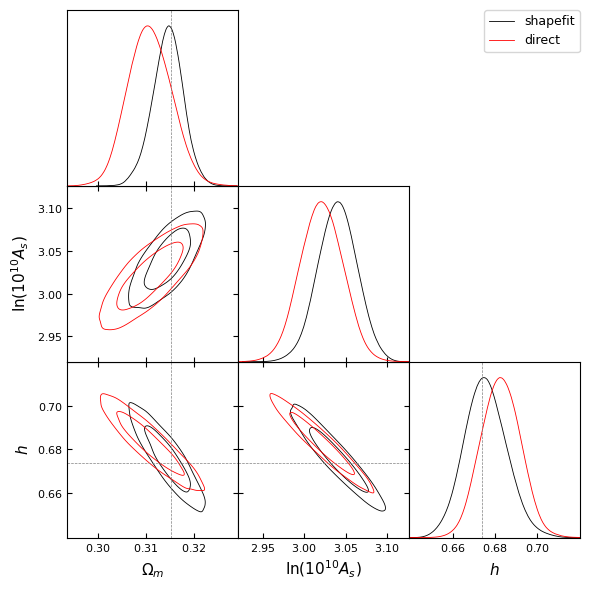

In [8]:
from desilike.samples import plotting
chain_shapefit = sampler.chains[0].remove_burnin(0.5)
chain_direct = Chain.load('_tests/chain_fs_direct_0.npy').remove_burnin(0.5)
plotting.plot_triangle([chain_shapefit, chain_direct], fill=True, labels=['shapefit', 'direct'], markers={'Omega_m': fiducial.Omega0_m, 'h': fiducial.h, 'A_s': fiducial.A_s, 'n_s': fiducial.n_s})